# Conditional Manatees

This chapter focusses on building linear models where there are interactions between the variable, instead of assuming the indpendence of models we built in earlier chapters. These interactions can be between categorical or continuous variables.

The chapter starts with an examination of the relationship between geographic ruggedness and GDP, and understanding if that is different between African and non-african countries

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
az.rcParams["stats.information_criterion"] = "waic"  # set information criterion to use in `compare`
az.rcParams["stats.ic_scale"] = "deviance"  # set information criterion scale
np.random.seed(0)

In [4]:
d = pd.read_csv("rugged.csv", delimiter=";")

# make log version of the outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d.dropna(subset=["log_gdp"])

# rescale variables
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

In [5]:
dd.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.000,7.492609,0.879712,0.138342
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0.0,NaN,NaN,NaN,NaN,200000.0,100.000,8.216929,0.964755,0.552564
7,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360.0,23.913,...,0.0,NaN,NaN,NaN,NaN,19200.0,0.000,9.933263,1.166270,0.123992
8,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669.0,-35.396,...,0.0,NaN,NaN,NaN,NaN,276632.0,89.889,9.407032,1.104485,0.124960
9,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820.0,40.294,...,0.0,NaN,NaN,NaN,NaN,105743.0,0.500,7.792343,0.914904,0.433409


Each row in these data is a country, and the various columns are economic, geographic, and historical features. Raw Magnitudes of GDP and terrain riggedness aren't meaningful to humans. So I've scaled the variables to make the units easier to work with. The usual standardisation is to subtract the mean and divide by the standard deviation. This makes the variable into z scores. We don't want to do that here, because zero ruggedness is meaningful. So instead terrain ruggedness is divided by the maximim value observed. This means it ends up scaled from totally flat (zero) to the maximum in the sample 1. Similarly log GDP is divided by the average value, so it is rescaled as a proportion of the international average.

To build a bayesian model for this relationship, we'll again use out geocentric skeleton

log(yi) = Normal(mu,sigma)

mu = alpha + beta(r_i-rbar)

where yi is the GDP for nation i, r_i is terrain ruggedness for nation i and rbar is the average ruggedness in thw whole sample. Remember that using rbar just makes it easier to assign a prior to the intercept alpha.

The hard thinking here comes when we specify priors. If you are like me, you don't have much scientific information about pleasuable associations between log GDP and terrain ruggedness. But even when we don't know much about the context, the measurements themselves constrain the priors in useful ways. The scaled outcome and predictor will make this easier. Consider the dirst intercept, alpha, defined as log GDP when ruggedness is the sample mean. So it must be close to one, because we scaled the outcome so that the mean is 1.

lets start with alpha = Normal(1,1)

Now for the beta slope. If we centre it on zero, that indicates no biad for positive or negative which makes sense.

Lets build our fiest candidate model:

In [7]:
with pm.Model() as m_8_1:
    a = pm.Normal("a", 1, 1)
    b = pm.Normal("b", 0, 1)

    mu = a + b * (dd["rugged_std"] - dd['rugged_std'].mean())  
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, shape=dd.shape[0])

We are not going to look at the posterior predictions yet, but rather at the prior predictions. Lets extract the prior and plot the implied lines

In [8]:
with m_8_1:
    m_8_1_prior = pm.sample_prior_predictive()

Lets have a look at those priors, what do they tell us, and can we make sensible refinements to them before calculating the posterior. Looking at the plot below (left hand side) we can observe a few things:

The lines are absolutely crazy and all over the place. the strength of some of the relationships are massive and surely not real. Remember we have standardised the two variables.

The lines from the prior trend both positive and negative, thats good.

Considering the mesurement scales, the lines have to pass closer to one. (so we need to tighten the prior for alpha)

At the same time the slopes are too variable. It is not plausable that terrain ruggedness explains most of the observed variation in log GDP.

In [11]:
with pm.Model() as m_8_1t:
    a = pm.Normal("a", 1, 0.1)
    b = pm.Normal("b", 0, 0.3)

    mu = a + b * (dd["rugged_std"] - dd['rugged_std'].mean())
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_1t_trace = pm.sample()

    m_8_1t_prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1234.28draws/s]


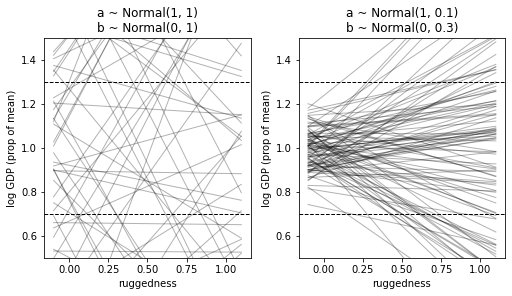

In [12]:
# Figure 8.3

_, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 4], constrained_layout=True)

n = 100
rugged_plot = np.linspace(-0.1, 1.1)
ax1.plot(
    rugged_plot,
    m_8_1_prior["a"][:n].T + rugged_plot.reshape(-1, 1) * m_8_1_prior["b"][:n].T,
    color="k",
    lw=1,
    alpha=0.3,
)
ax1.set_title("a ~ Normal(1, 1)\nb ~ Normal(0, 1)")

ax2.plot(
    rugged_plot,
    m_8_1t_prior["a"][:n].T + rugged_plot.reshape(-1, 1) * m_8_1t_prior["b"][:n].T,
    color="k",
    lw=1,
    alpha=0.3,
)
ax2.set_title("a ~ Normal(1, 0.1)\nb ~ Normal(0, 0.3)")

for ax in (ax1, ax2):
    ax.set_xlabel("ruggedness")
    ax.set_ylabel("log GDP (prop of mean)")
    ax.axhline(0.7, ls="dashed", color="k", lw=1)
    ax.axhline(1.3, ls="dashed", color="k", lw=1)
    ax.set_ylim(0.5, 1.5)

The slopes on the right are still implausably strong, but its a much better position than the previous set of priors

In [13]:
az.summary(m_8_1t_trace, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
a,1.00,0.01,0.98,1.02
b,0.00,0.06,-0.10,0.10
sigma,0.14,0.01,0.12,0.15


Looking at the summary for beta once we have run the model for the updated priors, we can see that there is a significant amount of probability mass above and below zero for beta. So really no association.

Lets split apart the continents and have another look

## Adding an indicator variable isn't enough
The first thing to realise is that just including an indicator variable for african nations, won't reveal the reversed slope. To build a model that allows nations inside and outside of africa to have different intercepts, we need to modify the model for mu, so that the mean is conditional on the continent. The conventional way to do this would be to just add another term to the linear model.

However this convention is often a bad idea. The problem here, and in general is that we need a prior for the new africa term. Okay, we can do priors. But what that prior will necessarily do is tell the model that mu for a nation in africais more uncertain, before seeing the data, than a mu outside of africa, and that makes no sense.

Thinking about this again

mu = alpha + beta x + gamma*africa

As africa is a categorical variable, the uncertainty from the gamma is only present when africa = 1

There is a simple solution. Nations in africa will get one intercept and those outside africa another.

In [14]:
cid = pd.Categorical(dd["cont_africa"])

using this approach, instead of the conventional approach of adding another term with the 0/1 indicator variable, doesn't force us to say that the mean for africa is inherently less certain than the mean for all other continents. We can just reuse the same prior as before. But keep in mind this is still structurally the same model you'd get in the conventional approach, it is jsut much easier this way to assign sensible priors.

In [28]:
with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[cid] + b[cid] * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1012.18draws/s]


In [29]:
az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_3_trace})

/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/stats/stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_8_2,0,-259.251280,4.954355,0.000000,1.0,12.865919,0.000000,True,deviance
m_8_1t,1,-188.626096,2.700043,70.625184,0.0,14.900400,14.958548,False,deviance


In [30]:
az.summary(m_8_3_trace, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
a[0],1.05,0.01,1.03,1.07
a[1],0.89,0.02,0.86,0.92
b[0],-0.14,0.06,-0.25,-0.04
b[1],0.13,0.08,-0.01,0.27
sigma,0.11,0.01,0.10,0.12


The parameter [1] is the intercept for african countries. It seems reliably lower than [0]

So lets remember what this summary table is telling us:

For [1] - the aftican nations:
the intercept (mean) is lower. This makes sense as we know african nations are under-developed relative to non african nations for a whole bunch of historical reasons.

The gradient is positive. This means the more rugged a place is, the higher its logGDP is. This is contrary to the rest of the world

In [31]:
az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_3_trace}, ic="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_8_2,0,-259.124224,5.017882,0.000000,1.0,12.673461,0.000000,False,deviance
m_8_1t,1,-188.616599,2.704791,70.507625,0.0,14.627374,14.970048,False,deviance


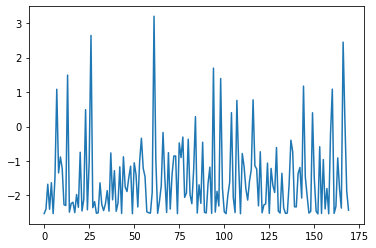

In [32]:
m_8_3_loo = az.loo(m_8_3_trace, pointwise=True)

plt.plot(m_8_3_loo.loo_i)

## Plotting the interaction. 
Plotting this model doesn’t really require any new tricks. The goal is to make two plots. In the first, we’ll display nations in Africa and overlay the posterior mean regression line and the 97% interval of that line. In the second, we’ll display nations outside of Africa instead.

In [33]:
with m_8_3:
    m_8_3_posterior = pm.sample_posterior_predictive(m_8_3_trace, var_names=["a", "b"])

100%|██████████| 2000/2000 [00:00<00:00, 24680.36it/s]


Text(0, 0.5, 'log GDP (as proportion of mean)')

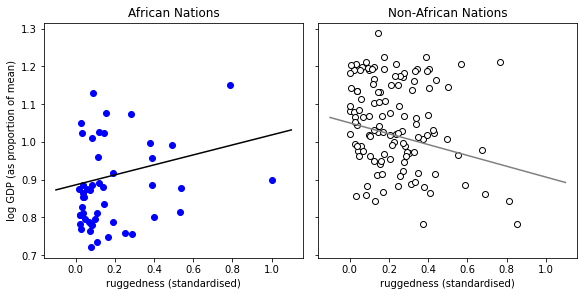

In [36]:
_, axs = plt.subplots(
    1,
    2,
    figsize=[8, 4],
    sharey=True,
    constrained_layout=True,
)

ax1, ax0 = axs

rugged_plot = np.linspace(-0.1, 1.1)

ax0.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC3
pred0 = m_8_3_posterior["a"][:, 0] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 0]
ax0.plot(rugged_plot, pred0.mean(1), color="grey")
ax0.set_title("Non-African Nations")

ax1.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC3
pred1 = m_8_3_posterior["a"][:, 1] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 1]
ax1.plot(rugged_plot, pred1.mean(1), color="k")
ax1.set_title("African Nations")


ax.set_xlim(-0.1, 1.1)
ax0.set_xlabel("ruggedness (standardised)")
ax1.set_xlabel("ruggedness (standardised)")
ax0.set_ylabel("")
ax1.set_ylabel("log GDP (as proportion of mean)")